In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import optuna

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
import keras.backend as k
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Permute, Conv1D, MaxPooling1D, BatchNormalization, Input, Flatten, Multiply
from keras.optimizers import RMSprop, Adam
from keras.callbacks import History
from keras import callbacks
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpMode"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = (y_true.index)+1

    return df_train, df_test, y_true

In [4]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

<ipython-input-3-e13a5a1ee8c5>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
<ipython-input-3-e13a5a1ee8c5>:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
<ipython-input-3-e13a5a1ee8c5>:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])


((20631, 20), (13096, 19), (100, 2))

In [5]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
df_train.head(5)

,UnitNumber,Cycle,OpMode1,OpMode2,OpMode3,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL
0,1,1,-0.080460,-0.666667,-1.0,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.600784,-0.272028,-0.333333,0.426357,0.449323,191
1,1,2,0.218391,-0.500000,-1.0,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.674373,-0.177376,-0.333333,0.333333,0.462027,190
2,1,3,-0.494253,0.500000,-1.0,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.656414,-0.285110,-0.666667,0.255814,0.242751,189
3,1,4,0.080460,0.000000,-1.0,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.650222,-0.666795,-0.333333,0.147287,0.324772,188
4,1,5,-0.218391,-0.333333,-1.0,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.650532,-0.195845,-0.166667,0.178295,0.409003,187


In [7]:
df_test.head(5)

,UnitNumber,Cycle,OpMode1,OpMode2,OpMode3,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,-1.0,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.735680,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-1.0,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.590463,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-1.0,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.688719,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-1.0,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.659820,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-1.0,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.694499,-0.398230,-0.666667,0.317829,0.432753


In [8]:
y_true.head()

,RUL,UnitNumber
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [9]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

In [10]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [11]:
def gen_test(id_df, seq_length, seq_cols):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)

    id_df = pd.concat([df_mask, id_df], ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    start = num_elements-seq_length
    stop = num_elements

    lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

In [12]:
sequence_length = 30

In [13]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(17731, 30, 17)


In [14]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(17731,)

In [15]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 30, 17)


In [16]:
#true target of test
y_test = y_true.RUL.values
y_test.shape

(100,)

In [17]:
rul_max = 125
corrected_y_train = np.where(y_train > rul_max, rul_max, y_train)
corrected_y_test = np.where(y_test > rul_max, rul_max, y_test)

In [18]:
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train, corrected_y_train, test_size=0.2, random_state=42
)

In [ ]:
nb_features = x_train.shape[2]
nb_out = 1

In [ ]:
nb_features

17

In [20]:
def objective(trial):

    filters = trial.suggest_int('filters', 64, 128)
    kernel_size = trial.suggest_int('kernel_size', 3, 5)
    pool_size = trial.suggest_int('pool_size', 2, 4)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    inputs = Input(shape=(30, 17))

    x = Conv1D(filters = filters, kernel_size = kernel_size)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=pool_size, strides=1)(x)

    x = Conv1D(filters = filters, kernel_size = kernel_size)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=pool_size, strides=1)(x)

    x = Permute((2, 1))(x)
    importance = Dense(1, activation='sigmoid')(x)
    attention_probs = Dense(x.shape[-1], activation='softmax')(importance)
    attention_scores = Multiply()([x, attention_probs])
    attention_scores = Permute((2,1))(attention_scores)

    x = Flatten()(attention_scores)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(units=1, activation='relu')(x)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)
    history = model.fit(x_train_split, y_train_split, epochs=32, batch_size=64,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                                                   patience=15, verbose=1, mode='auto',
                                                                   restore_best_weights=True), reduce_lr])

    val_rmse = history.history['val_root_mean_squared_error'][-1]

    return val_rmse


In [21]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=12)

print('Best trial:', study.best_trial.params)

[I 2024-12-20 05:16:19,196] A new study created in memory with name: no-name-d4a4ee34-e390-46dc-9f7d-d4a990ab74a3


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 7774.3315 - root_mean_squared_error: 88.1143 - val_loss: 6113.6289 - val_root_mean_squared_error: 78.1897 - learning_rate: 5.1939e-04
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4191.1230 - root_mean_squared_error: 64.6149 - val_loss: 2761.1252 - val_root_mean_squared_error: 52.5464 - learning_rate: 5.1939e-04
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1435.3920 - root_mean_squared_error: 37.7599 - val_loss: 2312.7683 - val_root_mean_squared_error: 48.0912 - learning_rate: 5.1939e-04
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 408.5414 - root_mean_squared_error: 20.1675 - val_loss: 1192.6866 - val_root_mean_squared_error: 34.5353 - learning_rate: 5.1939e-04
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 198.5269 - root_mean_squared_error: 14.0883 - val_loss: 718.7700 - val_root_mean_squared_error: 26.8099 - learning_rate: 5.1939e-04
Epoch 6/32
222/222 ━━━━━━━━━━━━

[I 2024-12-20 05:17:07,077] Trial 0 finished with value: 2.8994600772857666 and parameters: {'filters': 112, 'kernel_size': 4, 'pool_size': 3, 'dropout_rate': 0.1544588727952638, 'learning_rate': 0.0005193938314952937}. Best is trial 0 with value: 2.8994600772857666.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 4291.1123 - root_mean_squared_error: 63.7709 - val_loss: 2518.0146 - val_root_mean_squared_error: 50.1798 - learning_rate: 0.0041
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 224.6801 - root_mean_squared_error: 14.9750 - val_loss: 3331.9797 - val_root_mean_squared_error: 57.7233 - learning_rate: 0.0041
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 122.8524 - root_mean_squared_error: 11.0791 - val_loss: 253.4515 - val_root_mean_squared_error: 15.9202 - learning_rate: 0.0041
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 83.2547 - root_mean_squared_error: 9.1208 - val_loss: 1136.6700 - val_root_mean_squared_error: 33.7145 - learning_rate: 0.0041
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 78.1251 - root_mean_squared_error: 8.8135 - val_loss: 308.7201 - val_root_mean_squared_error: 17.5704 - learning_rate: 0.0041
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss

[I 2024-12-20 05:17:51,554] Trial 1 finished with value: 2.7120394706726074 and parameters: {'filters': 90, 'kernel_size': 3, 'pool_size': 4, 'dropout_rate': 0.15084694179890196, 'learning_rate': 0.004102566577720279}. Best is trial 1 with value: 2.7120394706726074.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 5209.7578 - root_mean_squared_error: 71.1408 - val_loss: 1700.9897 - val_root_mean_squared_error: 41.2431 - learning_rate: 0.0029
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 244.9579 - root_mean_squared_error: 15.6407 - val_loss: 448.7371 - val_root_mean_squared_error: 21.1834 - learning_rate: 0.0029
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 150.6646 - root_mean_squared_error: 12.2443 - val_loss: 201.6255 - val_root_mean_squared_error: 14.1995 - learning_rate: 0.0029
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 108.2750 - root_mean_squared_error: 10.4001 - val_loss: 659.0042 - val_root_mean_squared_error: 25.6711 - learning_rate: 0.0029
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 74.2486 - root_mean_squared_error: 8.6111 - val_loss: 70.0483 - val_root_mean_squared_error: 8.3695 - learning_rate: 0.0029
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 

[I 2024-12-20 05:18:36,178] Trial 2 finished with value: 2.4376556873321533 and parameters: {'filters': 77, 'kernel_size': 5, 'pool_size': 4, 'dropout_rate': 0.15205770215762737, 'learning_rate': 0.002944603998448471}. Best is trial 2 with value: 2.4376556873321533.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 8059.6616 - root_mean_squared_error: 89.7717 - val_loss: 7866.6167 - val_root_mean_squared_error: 88.6939 - learning_rate: 2.2772e-04
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6916.9106 - root_mean_squared_error: 83.1561 - val_loss: 5688.4399 - val_root_mean_squared_error: 75.4217 - learning_rate: 2.2772e-04
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5469.6206 - root_mean_squared_error: 73.9304 - val_loss: 3799.0740 - val_root_mean_squared_error: 61.6366 - learning_rate: 2.2772e-04
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3966.7649 - root_mean_squared_error: 62.9619 - val_loss: 2718.5002 - val_root_mean_squared_error: 52.1392 - learning_rate: 2.2772e-04
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2724.2415 - root_mean_squared_error: 52.1714 - val_loss: 1758.2188 - val_root_mean_squared_error: 41.9311 - learning_rate: 2.2772e-04
Epoch 6/32
222/222 ━━━━━━━━━━

[I 2024-12-20 05:19:19,608] Trial 3 finished with value: 7.759260654449463 and parameters: {'filters': 85, 'kernel_size': 4, 'pool_size': 4, 'dropout_rate': 0.2963159423999244, 'learning_rate': 0.00022772342352275502}. Best is trial 2 with value: 2.4376556873321533.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 8220.7568 - root_mean_squared_error: 90.6631 - val_loss: 8067.8462 - val_root_mean_squared_error: 89.8212 - learning_rate: 4.0486e-05
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7951.6963 - root_mean_squared_error: 89.1674 - val_loss: 7896.2173 - val_root_mean_squared_error: 88.8607 - learning_rate: 4.0486e-05
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7890.4380 - root_mean_squared_error: 88.8263 - val_loss: 7642.8066 - val_root_mean_squared_error: 87.4231 - learning_rate: 4.0486e-05
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7638.2266 - root_mean_squared_error: 87.3934 - val_loss: 7370.6846 - val_root_mean_squared_error: 85.8527 - learning_rate: 4.0486e-05
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7422.4761 - root_mean_squared_error: 86.1517 - val_loss: 7117.6636 - val_root_mean_squared_error: 84.3662 - learning_rate: 4.0486e-05
Epoch 6/32
222/222 ━━━━━━━━━━

[I 2024-12-20 05:20:02,715] Trial 4 finished with value: 36.81504440307617 and parameters: {'filters': 102, 'kernel_size': 3, 'pool_size': 4, 'dropout_rate': 0.3664009128518121, 'learning_rate': 4.048598684659465e-05}. Best is trial 2 with value: 2.4376556873321533.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 8386.1992 - root_mean_squared_error: 91.5740 - val_loss: 8109.3433 - val_root_mean_squared_error: 90.0519 - learning_rate: 1.6869e-05
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8286.1592 - root_mean_squared_error: 91.0257 - val_loss: 8057.8218 - val_root_mean_squared_error: 89.7654 - learning_rate: 1.6869e-05
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8134.6968 - root_mean_squared_error: 90.1912 - val_loss: 8000.6514 - val_root_mean_squared_error: 89.4464 - learning_rate: 1.6869e-05
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8087.7534 - root_mean_squared_error: 89.9310 - val_loss: 7943.1938 - val_root_mean_squared_error: 89.1246 - learning_rate: 1.6869e-05
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8093.5972 - root_mean_squared_error: 89.9624 - val_loss: 7892.2827 - val_root_mean_squared_error: 88.8385 - learning_rate: 1.6869e-05
Epoch 6/32
222/222 ━━━━━━━━━

[I 2024-12-20 05:20:48,322] Trial 5 finished with value: 76.31358337402344 and parameters: {'filters': 81, 'kernel_size': 4, 'pool_size': 3, 'dropout_rate': 0.21769953640255055, 'learning_rate': 1.6868601932653405e-05}. Best is trial 2 with value: 2.4376556873321533.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 8230.2578 - root_mean_squared_error: 90.7194 - val_loss: 8107.2788 - val_root_mean_squared_error: 90.0404 - learning_rate: 1.6650e-05
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8199.4502 - root_mean_squared_error: 90.5502 - val_loss: 8029.2290 - val_root_mean_squared_error: 89.6060 - learning_rate: 1.6650e-05
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8057.4946 - root_mean_squared_error: 89.7612 - val_loss: 7921.7588 - val_root_mean_squared_error: 89.0043 - learning_rate: 1.6650e-05
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7984.9790 - root_mean_squared_error: 89.3584 - val_loss: 7826.8740 - val_root_mean_squared_error: 88.4696 - learning_rate: 1.6650e-05
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7887.6816 - root_mean_squared_error: 88.8091 - val_loss: 7728.8940 - val_root_mean_squared_error: 87.9141 - learning_rate: 1.6650e-05
Epoch 6/32
222/222 ━━━━━━━━━

[I 2024-12-20 05:21:36,102] Trial 6 finished with value: 66.60906982421875 and parameters: {'filters': 127, 'kernel_size': 3, 'pool_size': 4, 'dropout_rate': 0.15680982277784572, 'learning_rate': 1.6650165732553266e-05}. Best is trial 2 with value: 2.4376556873321533.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 7988.4824 - root_mean_squared_error: 89.3715 - val_loss: 7446.4067 - val_root_mean_squared_error: 86.2926 - learning_rate: 2.8623e-04
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6802.2749 - root_mean_squared_error: 82.4687 - val_loss: 5920.5210 - val_root_mean_squared_error: 76.9449 - learning_rate: 2.8623e-04
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5405.3086 - root_mean_squared_error: 73.4950 - val_loss: 4065.2192 - val_root_mean_squared_error: 63.7591 - learning_rate: 2.8623e-04
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3907.1270 - root_mean_squared_error: 62.4818 - val_loss: 2439.9077 - val_root_mean_squared_error: 49.3954 - learning_rate: 2.8623e-04
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2535.5107 - root_mean_squared_error: 50.3387 - val_loss: 2556.8103 - val_root_mean_squared_error: 50.5649 - learning_rate: 2.8623e-04
Epoch 6/32
222/222 ━━━━━━━━━

[I 2024-12-20 05:22:25,975] Trial 7 finished with value: 14.06343936920166 and parameters: {'filters': 86, 'kernel_size': 4, 'pool_size': 2, 'dropout_rate': 0.14972860992304668, 'learning_rate': 0.0002862254410057587}. Best is trial 2 with value: 2.4376556873321533.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 8151.3438 - root_mean_squared_error: 90.2806 - val_loss: 8106.6118 - val_root_mean_squared_error: 90.0367 - learning_rate: 2.1668e-05
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8123.9463 - root_mean_squared_error: 90.1303 - val_loss: 8026.5439 - val_root_mean_squared_error: 89.5910 - learning_rate: 2.1668e-05
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8150.7124 - root_mean_squared_error: 90.2785 - val_loss: 7896.1011 - val_root_mean_squared_error: 88.8600 - learning_rate: 2.1668e-05
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7917.6299 - root_mean_squared_error: 88.9787 - val_loss: 7790.8843 - val_root_mean_squared_error: 88.2660 - learning_rate: 2.1668e-05
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7795.3975 - root_mean_squared_error: 88.2902 - val_loss: 7679.0283 - val_root_mean_squared_error: 87.6301 - learning_rate: 2.1668e-05
Epoch 6/32
222/222 ━━━━━━━━━

[I 2024-12-20 05:23:08,984] Trial 8 finished with value: 64.64195251464844 and parameters: {'filters': 112, 'kernel_size': 3, 'pool_size': 3, 'dropout_rate': 0.3322726185794485, 'learning_rate': 2.1668162398673112e-05}. Best is trial 2 with value: 2.4376556873321533.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 5179.8901 - root_mean_squared_error: 70.9521 - val_loss: 2726.8818 - val_root_mean_squared_error: 52.2196 - learning_rate: 0.0021
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 218.4261 - root_mean_squared_error: 14.7535 - val_loss: 1229.2987 - val_root_mean_squared_error: 35.0614 - learning_rate: 0.0021
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 103.2480 - root_mean_squared_error: 10.1560 - val_loss: 1319.1437 - val_root_mean_squared_error: 36.3200 - learning_rate: 0.0021
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 85.9117 - root_mean_squared_error: 9.2540 - val_loss: 62.8261 - val_root_mean_squared_error: 7.9263 - learning_rate: 0.0021
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 64.1854 - root_mean_squared_error: 8.0068 - val_loss: 900.4941 - val_root_mean_squared_error: 30.0082 - learning_rate: 0.0021
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 

[I 2024-12-20 05:23:52,941] Trial 9 finished with value: 2.47710919380188 and parameters: {'filters': 115, 'kernel_size': 5, 'pool_size': 4, 'dropout_rate': 0.1697210539268566, 'learning_rate': 0.002129762482584402}. Best is trial 2 with value: 2.4376556873321533.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 3421.9692 - root_mean_squared_error: 56.1061 - val_loss: 7820.2925 - val_root_mean_squared_error: 88.4324 - learning_rate: 0.0097
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 184.5325 - root_mean_squared_error: 13.5786 - val_loss: 4052.6382 - val_root_mean_squared_error: 63.6603 - learning_rate: 0.0097
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 128.0384 - root_mean_squared_error: 11.3064 - val_loss: 2307.9734 - val_root_mean_squared_error: 48.0414 - learning_rate: 0.0097
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 93.4714 - root_mean_squared_error: 9.6673 - val_loss: 822.7914 - val_root_mean_squared_error: 28.6843 - learning_rate: 0.0097
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 96.7963 - root_mean_squared_error: 9.8277 - val_loss: 1261.8719 - val_root_mean_squared_error: 35.5228 - learning_rate: 0.0097
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss

[I 2024-12-20 05:24:36,146] Trial 10 finished with value: 4.157755374908447 and parameters: {'filters': 67, 'kernel_size': 5, 'pool_size': 2, 'dropout_rate': 0.233669546467191, 'learning_rate': 0.009731880182803769}. Best is trial 2 with value: 2.4376556873321533.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 6280.5972 - root_mean_squared_error: 78.7172 - val_loss: 2867.2820 - val_root_mean_squared_error: 53.5470 - learning_rate: 0.0019
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 395.4884 - root_mean_squared_error: 19.8377 - val_loss: 4192.3687 - val_root_mean_squared_error: 64.7485 - learning_rate: 0.0019
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 209.6854 - root_mean_squared_error: 14.4772 - val_loss: 2420.0803 - val_root_mean_squared_error: 49.1943 - learning_rate: 0.0019
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 125.6946 - root_mean_squared_error: 11.1904 - val_loss: 791.4158 - val_root_mean_squared_error: 28.1321 - learning_rate: 0.0019
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 92.6726 - root_mean_squared_error: 9.6191 - val_loss: 2591.0845 - val_root_mean_squared_error: 50.9027 - learning_rate: 0.0019
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

[I 2024-12-20 05:25:15,674] Trial 11 finished with value: 2.972203016281128 and parameters: {'filters': 73, 'kernel_size': 5, 'pool_size': 4, 'dropout_rate': 0.10110741535926443, 'learning_rate': 0.0019104471612482047}. Best is trial 2 with value: 2.4376556873321533.


Best trial: {'filters': 77, 'kernel_size': 5, 'pool_size': 4, 'dropout_rate': 0.15205770215762737, 'learning_rate': 0.002944603998448471}


In [22]:
best_params = study.best_trial.params
print(best_params)
inputs = Input(shape=(30, 17))

#CNN
x = Conv1D(filters = best_params['filters'], kernel_size = best_params['kernel_size'])(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=best_params['pool_size'], strides=1)(x)

x = Conv1D(filters = best_params['filters'], kernel_size = best_params['kernel_size'])(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=best_params['pool_size'], strides=1)(x)

#Attention Layer
x = Permute((2, 1))(x)
importance = Dense(1, activation='sigmoid')(x)
attention_probs = Dense(x.shape[-1], activation='softmax')(importance)
attention_scores = Multiply()([x, attention_probs])
attention_scores = Permute((2,1))(attention_scores)

x = Flatten()(attention_scores)
x = Dropout(best_params['dropout_rate'])(x)

outputs = Dense(units=1, activation='relu')(x)

model = Model(inputs, outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

{'filters': 77, 'kernel_size': 5, 'pool_size': 4, 'dropout_rate': 0.15205770215762737, 'learning_rate': 0.002944603998448471}


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 30, 17)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_24 (Conv1D)        │ (None, 26, 77)         │          6,622 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 26, 77)         │            308 │ conv1d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_24             │ (None, 26, 77)         │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_24          │ (None, 23, 77)         │              0 │ activation_24[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_25 (Conv1D)        │ (None, 19, 77)         │         29,722 │ max_pooling1d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 19, 77)         │            308 │ conv1d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_25             │ (None, 19, 77)         │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_25          │ (None, 16, 77)         │              0 │ activation_25[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_24 (Permute)      │ (None, 77, 16)         │              0 │ max_pooling1d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 77, 1)          │             17 │ permute_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 77, 16)         │             32 │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_12 (Multiply)    │ (None, 77, 16)         │              0 │ permute_24[0][0],      │
│                           │                        │                │ dense_37[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_25 (Permute)      │ (None, 16, 77)         │              0 │ multiply_12[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_12 (Flatten)      │ (None, 1232)           │              0 │ permute_25[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout) 

 Total params: 38,242 (149.38 KB)

 Trainable params: 37,934 (148.18 KB)

 Non-trainable params: 308 (1.20 KB)

In [23]:
%%time
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

history = model.fit(x_train_split, y_train_split, epochs=64, batch_size=64,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[early_stop, reduce_lr])

Epoch 1/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 5225.3110 - root_mean_squared_error: 71.1946 - val_loss: 3511.4102 - val_root_mean_squared_error: 59.2572 - learning_rate: 0.0029
Epoch 2/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 275.7352 - root_mean_squared_error: 16.5692 - val_loss: 656.8533 - val_root_mean_squared_error: 25.6291 - learning_rate: 0.0029
Epoch 3/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 131.7194 - root_mean_squared_error: 11.4675 - val_loss: 309.0863 - val_root_mean_squared_error: 17.5809 - learning_rate: 0.0029
Epoch 4/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 84.7077 - root_mean_squared_error: 9.2015 - val_loss: 3675.4448 - val_root_mean_squared_error: 60.6254 - learning_rate: 0.0029
Epoch 5/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 71.5023 - root_mean_squared_error: 8.4503 - val_loss: 583.4206 - val_root_mean_squared_error: 24.1541 - learning_rate: 0.0029
Epoch 6/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 

In [24]:
result_train = model.evaluate(x_train, corrected_y_train, verbose=1, batch_size=200)

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.4570 - root_mean_squared_error: 1.5670


In [25]:
result_test = model.evaluate(x_test, corrected_y_test, verbose=1, batch_size=64)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - loss: 354.2122 - root_mean_squared_error: 18.8113


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step


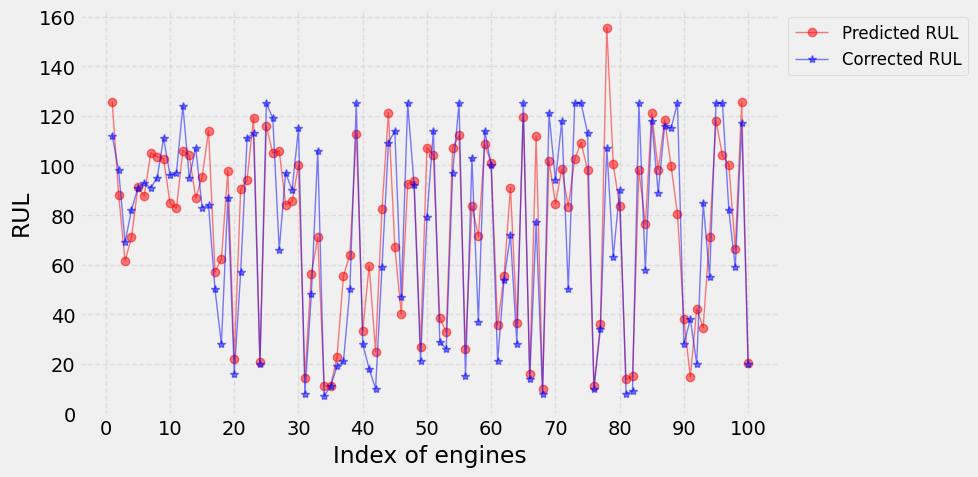

In [26]:
y_test_pred = model.predict(x_test)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(y_test_pred) + 1), y_test_pred, 'ro-', label='Predicted RUL', linewidth=1, alpha=0.5)
plt.plot(range(1, len(corrected_y_test) + 1), corrected_y_test, 'b*-', label='Corrected RUL', linewidth=1, alpha=0.5)
plt.ylabel("RUL")
plt.xlabel("Index of engines")
plt.xticks(ticks=np.arange(0, 101, 10))
plt.grid(True, which='both', linestyle='--', linewidth=1, alpha=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.tight_layout()
plt.show()